In [42]:
import pandas as pd

# CSV 파일 읽기
file_path = '/home/alpaco/mys/projects/news/datas/네이버_뉴스기사/naver_news_origin_duplicates.csv'
news_df = pd.read_csv(file_path, index_col=False, dtype={'href':str, 'context':str, 'stock':str, 'code':str})

# 필요한 열 선택 및 특정 코드 필터링
news_df = news_df[['context', 'stock', 'day', 'code', 'href']]
news_df = news_df[news_df['code'] == '260970'].reset_index(drop=True)

# 'day'가 같은 행의 'context' 통합
news_df = news_df.groupby(['day', 'code'], as_index=False).agg({
    'context': lambda x: ''.join(x),  # context를 순서대로 합치기
    'stock': 'first',                  # 첫 번째 'stock' 값 유지
    'href': lambda x: list(x)          # href를 리스트로 통합
})

# 'day' 값을 datetime 형식으로 변환
news_df['day'] = pd.to_datetime(news_df['day'], format='%Y%m%d').dt.date

# 'day'를 'yyyy년 m월 d일' 형식으로 변환하고 'context'에 추가
news_df['context'] = news_df.apply(lambda row: f"{row['day'].year}년 {row['day'].month}월 {row['day'].day}일 {row['stock']}의 통합 기사입니다. {row['context']}", axis=1)

# 'context' 내용을 순서대로 합쳐서 all_context라는 변수에 저장
all_context = ' '.join(news_df['context'].tolist())

# 날짜 오름차순 정렬 후 인덱스 재설정
news_df = news_df.sort_values(by='day', ascending=True).reset_index(drop=True)

# 결과 확인
print(news_df)
print("All Context:", all_context)


          day    code                                            context  \
0  2024-05-17  260970  2024년 5월 17일 에스앤디의 기사입니다. 삼천당제약·에스앤디 등 상위권  [서...   
1  2024-06-13  260970  2024년 6월 13일 에스앤디의 기사입니다. [이데일리 김보겸 기자] KB증권은 ...   

  stock                                               href  
0  에스앤디  [https://n.news.naver.com/mnews/article/011/00...  
1  에스앤디  [https://n.news.naver.com/mnews/article/018/00...  
All Context: 2024년 5월 17일 에스앤디의 기사입니다. 삼천당제약·에스앤디 등 상위권  [서울경제]  미래에셋증권에서 거래하는 고수익 투자자들이 17일 오전 가장 많이 순매수한 종목은 퓨처켐으로 나타났다. 삼천당제약(000250), 에스앤디(260970), HD현대중공업(329180) 등도 순매수 상위권에 올랐다.  이날 미래에셋증권에 따르면 미래에셋증권 주식 거래 고객 중 최근 1개월 간 투자수익률 상위 1%에 해당하는 ‘주식 초고수’들이 오전 11시까지 가장 많이 사들인 종목은 퓨쳐켐으로 집계됐다.  이날 오전 11시께 퓨쳐켐의 주가는 전 거래일 대비 350원(2.59%) 상승한 1만 3870원에 거래되고 있다. 퓨쳐켐은 방사성의약품 분야에서 20년 이상 경력을 갖춘 기업이다. 현재 생산 중인 방사성의약품은 파킨슨병, 알츠하이머, 암 진단에 쓰인다. 퓨쳐켐은 최근 전립선암 치료제 임상 2상을 시작했다고 밝혔다. 전립선암 환자는 미국에서만 연간 27만 명에 달하는 만큼 신약 개발에 대한 기대감이 커져 매수세가 몰린 것으로 풀이된다.  퓨쳐켐은 거세저항성 전이 환자를 대상으로 하는 전립선암 치료제 FC705가 미국 임상 2

In [12]:
news_df['context']

0    2024년 5월 17일 에스앤디의 기사입니다. 삼천당제약·에스앤디 등 상위권  [서...
1    2024년 6월 13일 에스앤디의 기사입니다. [이데일리 김보겸 기자] KB증권은 ...
Name: context, dtype: object

In [14]:
news_df['href'][1]

['https://n.news.naver.com/mnews/article/018/0005762640?sid=101',
 'https://n.news.naver.com/mnews/article/018/0005763136?sid=101']

In [15]:
# RAG 관련
import ollama
import chromadb

In [18]:
try :
    collections = client.list_collections()
except :
    client = chromadb.Client()
    collections = client.list_collections()

In [19]:

def get_embedding(prompt, model="mxbai-embed-large"):
    response = ollama.embeddings(prompt=prompt, model=model)
    return response["embedding"]

In [22]:
def chaek_collection(collections):
    collections = client.list_collections()
    context_exists = "context" in [collection.name for collection in collections]  # 컬렉션 존재 확인

    if context_exists:
        client.delete_collection('context')
        print("기존 컬렉션 삭제완료")
    else:
        print("컬렉션이 없습니다")

    collections = client.list_collections()  # 컬렉션 목록 업데이트
    context_exists = "context" in [collection.name for collection in collections]

    if context_exists:
        print("컬렉션이 이미 있습니다.")
    else:
        collection = client.create_collection(name='context')
        print("컬렉션 생성 완료")
        return collection

collection = chaek_collection(collections)

기존 컬렉션 삭제완료
컬렉션 생성 완료


In [23]:
# 문서 임베딩하고 컬렉션에 저장
for i, d in enumerate(news_df['context']):
  embedding = get_embedding(d)
  collection.add(
    ids=[str(i)],
    embeddings = [embedding],
    documents=[d]
  )

In [35]:
news_df['context'][0]

'2024년 5월 17일 에스앤디의 기사입니다. 삼천당제약·에스앤디 등 상위권  [서울경제]  미래에셋증권에서 거래하는 고수익 투자자들이 17일 오전 가장 많이 순매수한 종목은 퓨처켐으로 나타났다. 삼천당제약(000250), 에스앤디(260970), HD현대중공업(329180) 등도 순매수 상위권에 올랐다.  이날 미래에셋증권에 따르면 미래에셋증권 주식 거래 고객 중 최근 1개월 간 투자수익률 상위 1%에 해당하는 ‘주식 초고수’들이 오전 11시까지 가장 많이 사들인 종목은 퓨쳐켐으로 집계됐다.  이날 오전 11시께 퓨쳐켐의 주가는 전 거래일 대비 350원(2.59%) 상승한 1만 3870원에 거래되고 있다. 퓨쳐켐은 방사성의약품 분야에서 20년 이상 경력을 갖춘 기업이다. 현재 생산 중인 방사성의약품은 파킨슨병, 알츠하이머, 암 진단에 쓰인다. 퓨쳐켐은 최근 전립선암 치료제 임상 2상을 시작했다고 밝혔다. 전립선암 환자는 미국에서만 연간 27만 명에 달하는 만큼 신약 개발에 대한 기대감이 커져 매수세가 몰린 것으로 풀이된다.  퓨쳐켐은 거세저항성 전이 환자를 대상으로 하는 전립선암 치료제 FC705가 미국 임상 2a상 시험의 첫 환자 투여를 시작했다. 퓨쳐켐의 FC705는 절반의 투여량으로 피폭 등의 부작용은 최소화하면서 경쟁 약물 대비 높은 종양 섭취율로 치료 효과를 최대화하는 \'계열 내 최고(Best-in-class)\' 신약을 목표로 개발 중인 전립선암 치료제다. 앞서 임상 1상에서는 환자가 치료에 반응하는 비율인 객관적 반응률(ORR)과 질병통제율(DCR)이 100%로 나타났다.  순매수 2위에는 삼천당제약이 이름을 올렸다. 삼천당제약의 주가는 전 거래일 대비 4400원(3.96%) 오른 11만 5400원에 거래되고 있다. 삼천당제약은 지난 10일 경기도 화성 향남 공장에서 다회용 점안제 복제약 미국 수출 기념식을 진행했. 국내 제약사가 다회용 점안제를 미국에 수출하는 것은 이번이 처음이다. 삼천당제약이 자체 개발하고 미국 cGMP 인증을 받은 향남

In [36]:
client.get_collection("context").get()['documents']

['2024년 5월 17일 에스앤디의 기사입니다. 삼천당제약·에스앤디 등 상위권  [서울경제]  미래에셋증권에서 거래하는 고수익 투자자들이 17일 오전 가장 많이 순매수한 종목은 퓨처켐으로 나타났다. 삼천당제약(000250), 에스앤디(260970), HD현대중공업(329180) 등도 순매수 상위권에 올랐다.  이날 미래에셋증권에 따르면 미래에셋증권 주식 거래 고객 중 최근 1개월 간 투자수익률 상위 1%에 해당하는 ‘주식 초고수’들이 오전 11시까지 가장 많이 사들인 종목은 퓨쳐켐으로 집계됐다.  이날 오전 11시께 퓨쳐켐의 주가는 전 거래일 대비 350원(2.59%) 상승한 1만 3870원에 거래되고 있다. 퓨쳐켐은 방사성의약품 분야에서 20년 이상 경력을 갖춘 기업이다. 현재 생산 중인 방사성의약품은 파킨슨병, 알츠하이머, 암 진단에 쓰인다. 퓨쳐켐은 최근 전립선암 치료제 임상 2상을 시작했다고 밝혔다. 전립선암 환자는 미국에서만 연간 27만 명에 달하는 만큼 신약 개발에 대한 기대감이 커져 매수세가 몰린 것으로 풀이된다.  퓨쳐켐은 거세저항성 전이 환자를 대상으로 하는 전립선암 치료제 FC705가 미국 임상 2a상 시험의 첫 환자 투여를 시작했다. 퓨쳐켐의 FC705는 절반의 투여량으로 피폭 등의 부작용은 최소화하면서 경쟁 약물 대비 높은 종양 섭취율로 치료 효과를 최대화하는 \'계열 내 최고(Best-in-class)\' 신약을 목표로 개발 중인 전립선암 치료제다. 앞서 임상 1상에서는 환자가 치료에 반응하는 비율인 객관적 반응률(ORR)과 질병통제율(DCR)이 100%로 나타났다.  순매수 2위에는 삼천당제약이 이름을 올렸다. 삼천당제약의 주가는 전 거래일 대비 4400원(3.96%) 오른 11만 5400원에 거래되고 있다. 삼천당제약은 지난 10일 경기도 화성 향남 공장에서 다회용 점안제 복제약 미국 수출 기념식을 진행했. 국내 제약사가 다회용 점안제를 미국에 수출하는 것은 이번이 처음이다. 삼천당제약이 자체 개발하고 미국 cGMP 인증을 받은 향

In [40]:
# 컬렉션 쿼리 함수화
def query_collection(collection, embedding):
    results = collection.query(
        query_embeddings=[embedding],
        n_results=1
    )
    return results['documents'][0][0]

In [41]:
quetion = "에스앤디 2024년 5월 17일 기사 내용"
embedding = get_embedding(quetion)
data = query_collection(collection, embedding)
data

'2024년 6월 13일 에스앤디의 기사입니다. [이데일리 김보겸 기자] KB증권은 에스앤디(260970)에 대해 불닭볶음면 열풍으로 주요 고객사인 삼양식품(003230)과 동반 성장하고 있다고 평가했다. 일반기능식품소재 사업 다변화 역시 성장 모멘텀이 될 것이란 기대다. 재무구조도 양호하며 동종업체 대비 저평가된 종목으로 주목했다.    임상국 KB증권 연구원은 “비수기에도 불구하고 1분기 실적은 매출액 238억원, 영업이익 35억원으로 전년동기 대비 각각 30.8%, 72.2% 성장하며 실적 호조세가 이어졌다”고 밝혔다.  에스앤디는 일반기능식품 및 건강기능식품 소재를 생산하는 기업으로 2021년 9월 코넥스에서 코스닥 시장으로 이전 상장했다. 삼양식품(003230) 농심(004370) 풀무원(017810) CJ제일제당(097950) 등 약 158개의 고객사를 보유하고 있으며 230여종의 식품 소재를 생산하고 있다.  K-푸드 열풍에 힘입어 주요 고객사와 동반 성장하고 있다는 데 임 연구원은 주목했다. 삼양식품의 불닭시리즈가 중국, 동남아, 미국을 중심으로 매출액이 지속 증가하고 있으며 이는 불닭시리즈 액상, 분말 스프의 핵심 원료를 독점 공급하는 에스앤디의 동반 성장으로 이어지고 있다는 것이다.  임 연구원은 “글로벌 K-푸드, 특히 불닭 시리즈 열풍이 이어지며 불닭볶음면 소스 핵심 원료 매출이 전년 대비 42.7% 증가한 것”이라며 “영업이익률도 2023년 1분기 11.2%에서 14.8%로 큰 폭 상승했다”고 했다.  일반기능식품 소재 사업을 다변화하면서 차기 성장 모멘텀도 확보했다고 봤다. 임 연구원은 “기존 식품 소재 사업을 바탕으로 부가가치가 높은 간편식, 조미료 등 완제품 출시를 통해 시장 트렌드 변화에 탄력적으로 대응하며 또 다른 성장 모멘텀으로 작용할 수 있다”고 짚었다.  2024년 1분기 말 기준 유보율은 4305%, 자기자본이익률(ROE)은 12.7%, 현금성자산은 약 620억원, 무차입 경영 등으로 재무구조도 양호하다. 주가수익비율(P

In [46]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama

# Prompt 템플릿 정의
prompt = ChatPromptTemplate.from_messages([
    ("system", "이 시스템 이름은 InbestBot 입니다. {ability} 분석 전문 시스템 입니다. 한국인 '{username}'님에게 주식명을 입력받아 간단한 정보를 제공합니다. 단발성 대화입니다."),
    ("user", "{stock} 종목 통합 기사: {all_context}. / 질문 : {question}"),
])

# 출력 파서 정의
output_parser = StrOutputParser()

# 모델 정의
llm = ChatOllama(model='gemma2')

# 체인 구성
chain = prompt | llm | output_parser

# 질문을 정의
question = f"2024년 5월 17일 뉴스 내용에서 주요 소식을 알려주세요"

# 체인 호출
response = chain.invoke(
    {"stock": "에스앤디", "ability": "주식", "username": "문영식", "all_context": all_context, "question": question},   
)

# 결과 출력
print(response)



2024년 5월 17일 뉴스는 다음과 같은 주요 소식을 담고 있습니다.

* **美 증시, CPI 물가둔화에 긍정적 반응**: 미국 5월 소비자물가지수(CPI)가 둔화세를 보이며 나스닥 지수는 1% 이상 상승했습니다. 이는 미 연방준비제도(Fed·연준) 연방공개시장위원회(FOMC)에서 연내 한번 금리 인하를 시사하는 점표가 발표되었음에도 불구하고, 시장은 물가 둔화에 더욱 큰 반응을 보였다는 것을 나타냅니다.
* **코스닥 상승 마감**: 미 증시의 CPI 둔화세와 연준 금리 인하 시사에 따라 코스닥도 투자심리가 개선되면서 상승 마감했습니다.
* **외국인 순매수, 기관은 순매도**: 수급별로 외국인이 1736억원, 개인이 171억원 순매수를 기록했지만, 기관은 1885억원 순매도했습니다.
* **업종별 희비가 엇갈림**: 통신장비(2.61%)가 강세를 보였고, 디지털컨텐츠, 비금속 등이 소폭 상승했으며, 반면 기타제조(2.15%), 방송서비스(1.25%) 등은 하락했습니다.


* **시가총액 상위주, 종목별 등락 흐름 갈림**: 중앙첨단소재(24%↑)와 와이씨(17%↑), 브이티(8%), 펄어비스(5%)는 상승했지만, 대주전자재료(6%↓), 휴젤(3%↓), 리가켐바이오(3%↓) 등은 하락했습니다.
* **에스앤디, 불닭볶음면 소스 제조사라는 점이 부각되면서 상한가**: 화장품 수출 확대 전망에 힘입어 마녀공장(20%↑)과 선진뷰티사이언스(9%↑)도 상승했습니다.







2024-08-20 05:05:35.290510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 05:05:35.292064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 05:05:35.296345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 05:05:35.308771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 05:05:35.330078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

/home/alpaco/chs/data/model/02_LSTM/ckeckpointer.weights.h5


/home/alpaco/anaconda3/envs/inbest/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724097937.595924  176018 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 05:05:37.633498: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required li

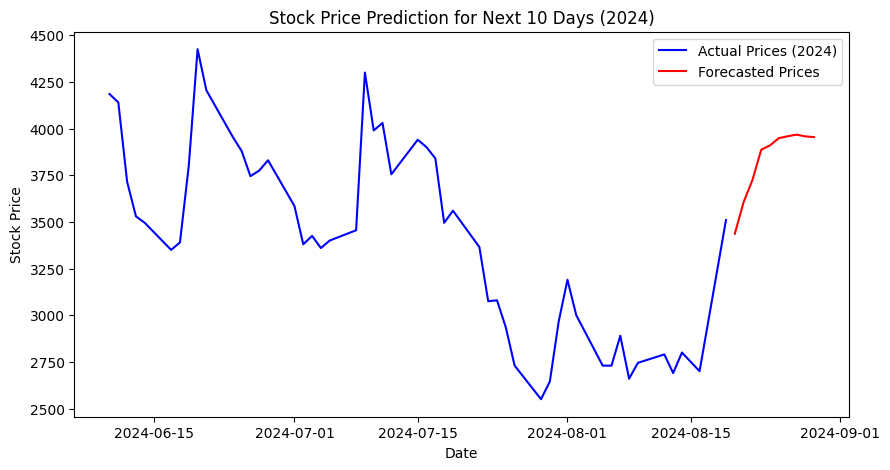

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import FinanceDataReader as fdr
from datetime import timedelta
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
STOCK_CODE = '110020'
df = fdr.DataReader(STOCK_CODE)
WINDOW_SIZE=20
filename = os.path.join('/home/alpaco/chs/data/model/02_LSTM', 'ckeckpointer.weights.h5')  # Change the filename here
print(filename)

model = Sequential([
# 1차원 feature map 생성
Conv1D(filters=32, kernel_size=5,
    padding="causal",
    activation="relu",
    input_shape=[WINDOW_SIZE, 1]),
# LSTM
LSTM(16, activation='tanh'),
Dense(16, activation="relu"),
Dense(1),
])

model.load_weights(filename)  # 학습한 모델 파일 로드

def new_func(df, filename):
    def plot_predict_chart(df):
        WINDOW_SIZE=20

    # 종가 데이터만 사용
        data = df['Close'].values
        data = data.reshape(-1, 1)

    # 이전에 학습된 스케일러와 동일한 범위로 정규화
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

    # 모델이 학습한 타임 스텝
        time_step = 20

    # 테스트 데이터셋 준비
        test_data = scaled_data[-time_step:]
        test_data = test_data.reshape(1, -1)
        temp_input = list(test_data)
        temp_input = temp_input[0].tolist()

        model = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",
            input_shape=[WINDOW_SIZE, 1]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])
    
        model.load_weights(filename)  # 학습한 모델 파일 로드

    # 향후 10일간 예측
        lst_output = []
        n_steps = time_step
        i = 0
        while i < 10:
            if len(temp_input) > time_step:
                x_input = np.array(temp_input[-time_step:])  # 최신 60일 데이터만 사용하도록 수정
                x_input = x_input.reshape((1, n_steps, 1))
            else:
                x_input = np.array(temp_input)
                x_input = x_input.reshape((1, n_steps, 1))

            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    # 결과를 원래 스케일로 되돌림
        predicted_stock_price = scaler.inverse_transform(lst_output)

    # 예측 결과 출력
        predicted_stock_price = scaler.inverse_transform(lst_output)

    # 예측 결과를 pandas Series로 변환 (날짜 인덱스 추가)
        last_date = df.index[-1]
        forecast_dates = [last_date + timedelta(days=i+1) for i in range(10)]
        forecast_series = pd.Series(predicted_stock_price.flatten(), index=forecast_dates)

    # 예측 결과 시각화 (2024년 이후 데이터만 포함)
        df_new = df[-50:]
        plt.figure(figsize=(10, 5))
        plt.plot(df_new['Close'], label='Actual Prices (2024)', color='blue')
        plt.plot(forecast_series, label='Forecasted Prices', color='red')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.title(f'Stock Price Prediction for Next 10 Days (2024)')
        plt.legend()
        plt.show()
    plot_predict_chart(df)

new_func(df, filename)